### Kaggle Competition: House Prices - Advanced Regression Techniques

Out of nearly 5,000 participants, I achieved a score of 0.11984, placing me in the top 5% of the competition.

In [1]:
%pip install catboost optuna

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
print(sys.executable)

/opt/conda/envs/anaconda-ai-2024.04-py310/bin/python


In [3]:
import catboost
print(catboost.__version__)

1.2.8


In [7]:
# Then import packages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
import scipy.stats
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor  # This will work after installation
import optuna # This will work after installation
import warnings
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [5]:
from catboost import CatBoostRegressor
import optuna

print("CatBoost and Optuna successfully imported!")

CatBoost and Optuna successfully imported!


In [10]:
# Load the data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

# Print the shapes of the dataframes
print(f"Train data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

# Display first few rows to confirm it's loaded correctly
print(df_train.head(5))

Train data shape: (1460, 81)
Test data shape: (1459, 80)
Sample submission shape: (1459, 2)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  Ov

This dataset contains detailed housing information for 1,460 homes, each described by 79 features (like lot size, quality, and year built). The goal is to predict the `SalePrice`. The test set has 1,459 rows, missing only the target column. Categorical, numerical, and ordinal variables are all present.

In [11]:
# check duplicates
df_train.duplicated().sum()

0

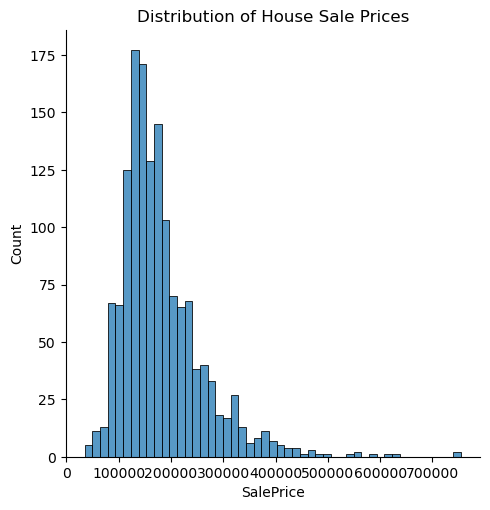

In [14]:
sns.displot(df_train['SalePrice'], kde=False)
plt.xlabel('SalePrice')
plt.ylabel('Count')
plt.title('Distribution of House Sale Prices')
plt.show()

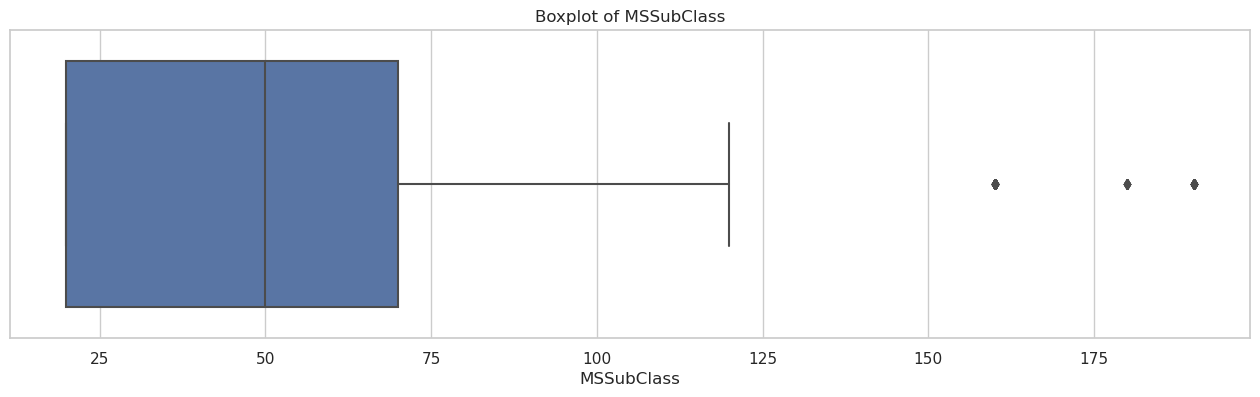

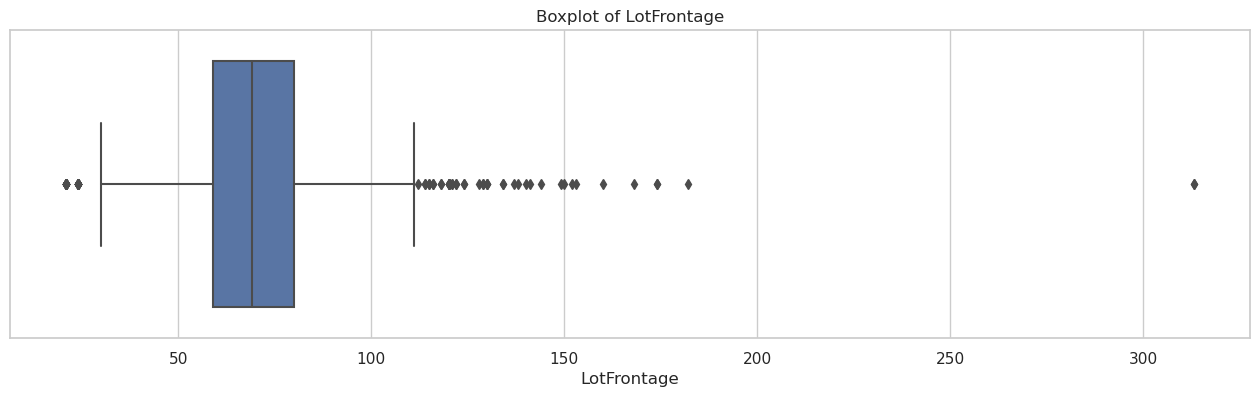

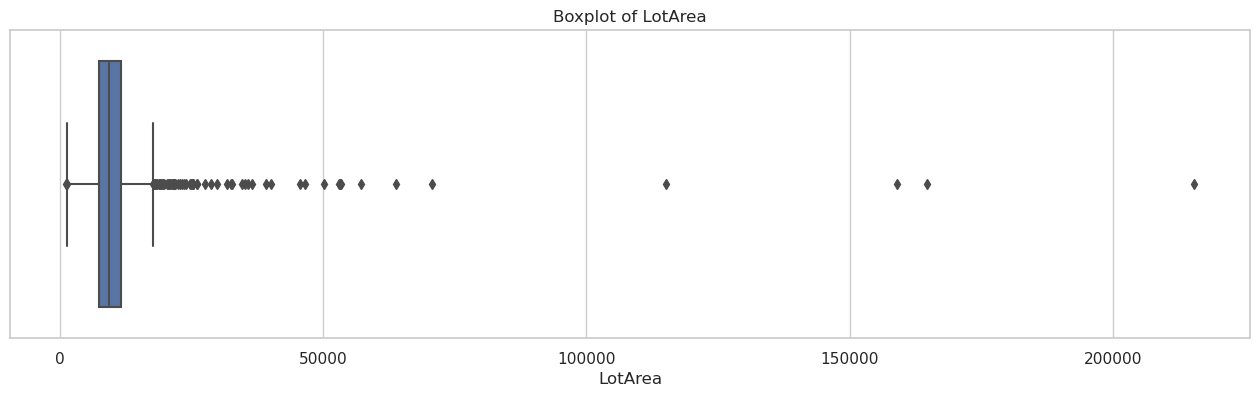

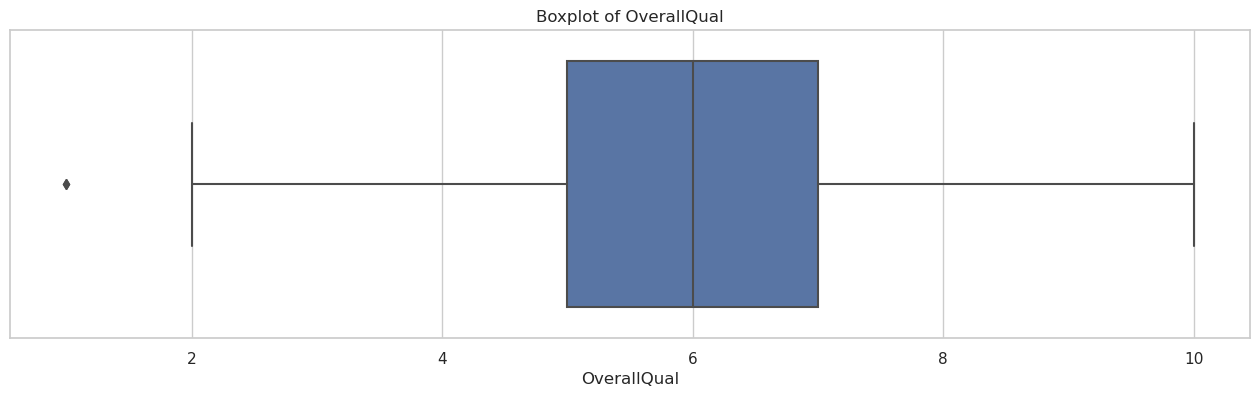

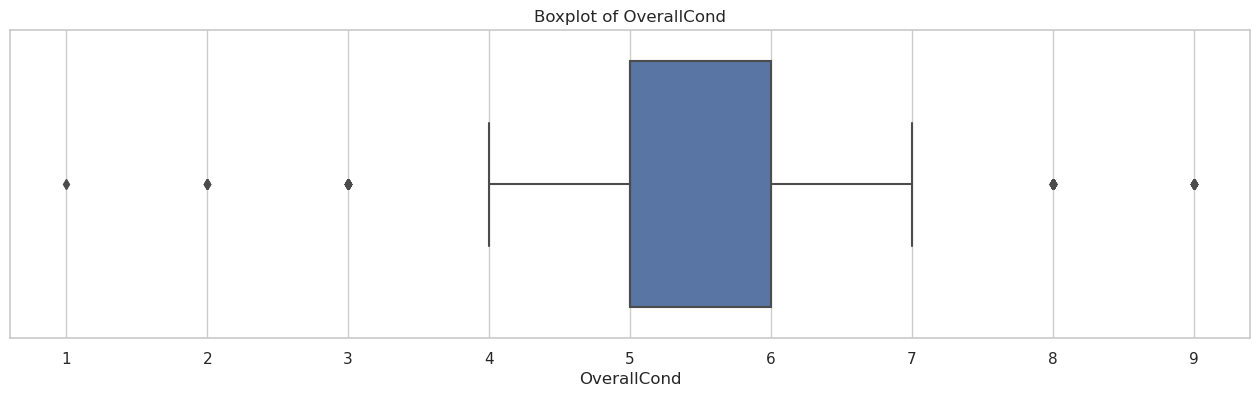

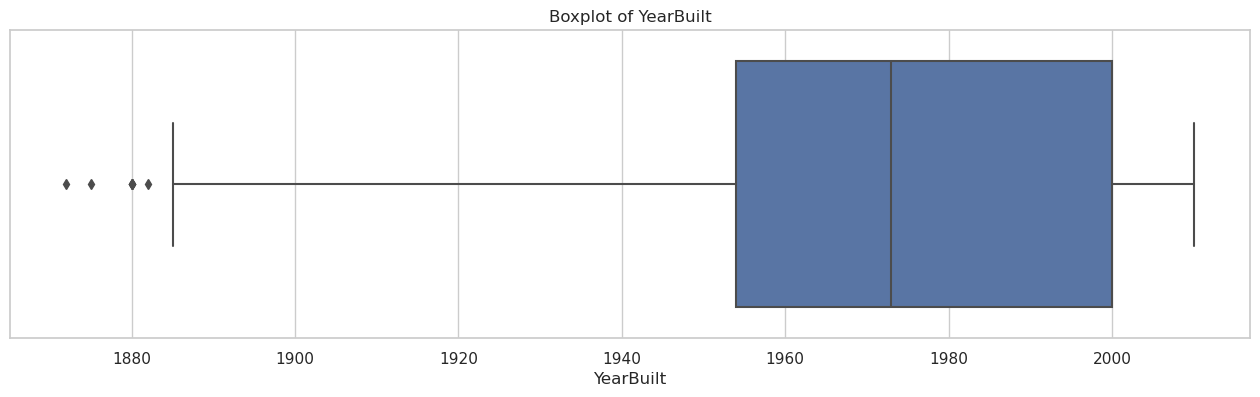

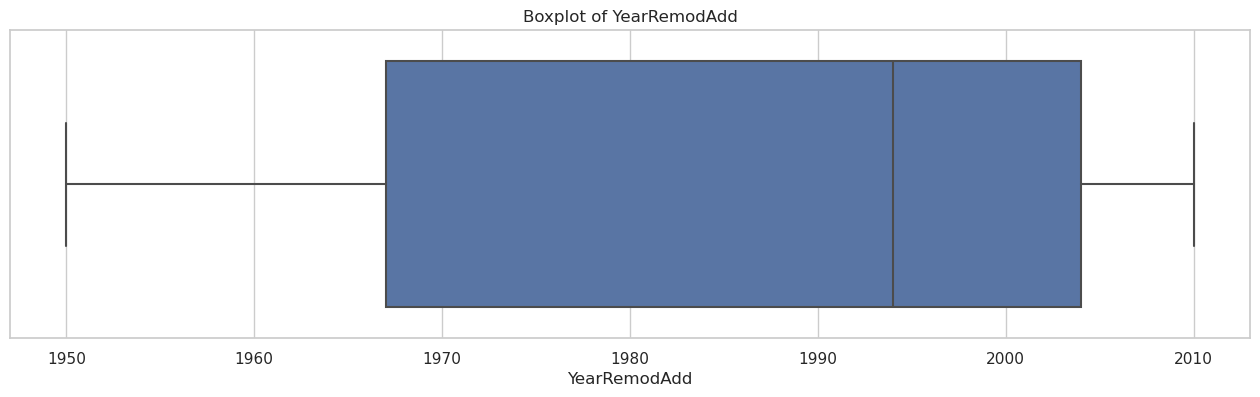

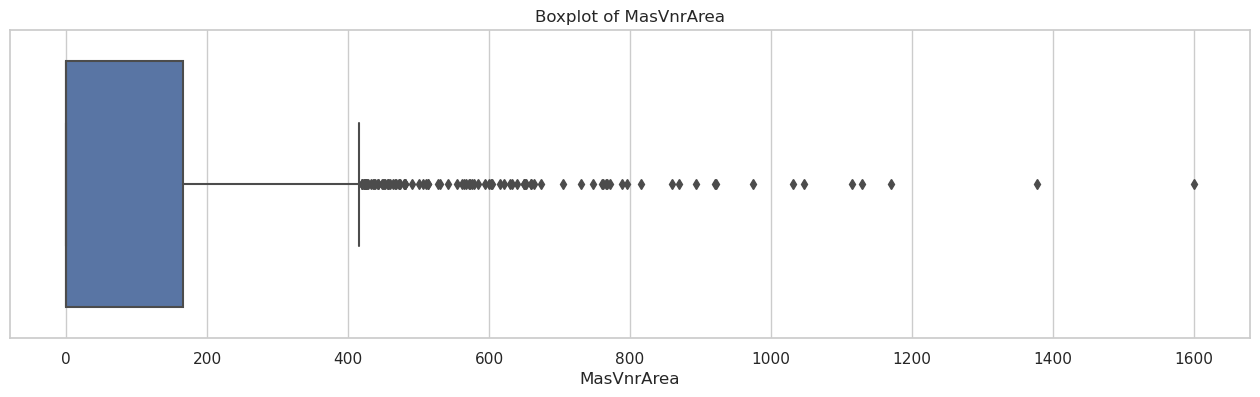

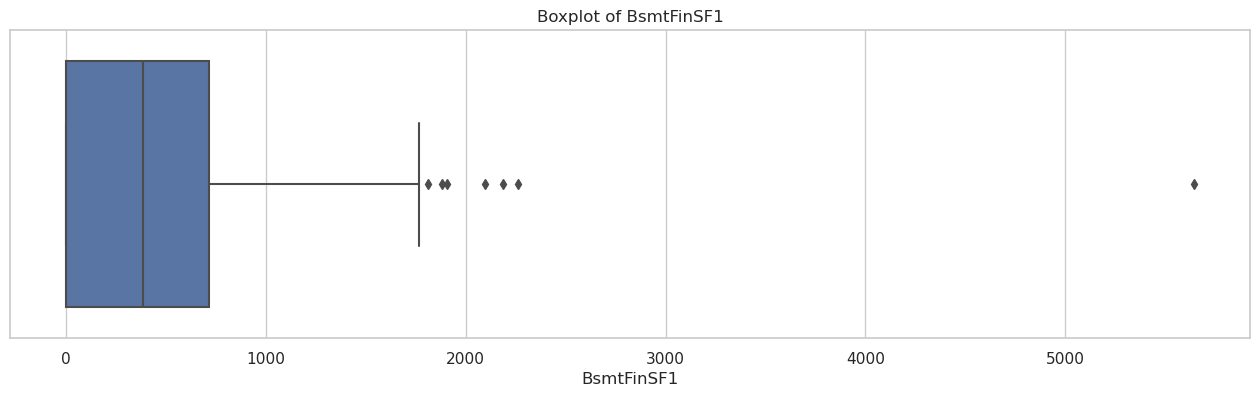

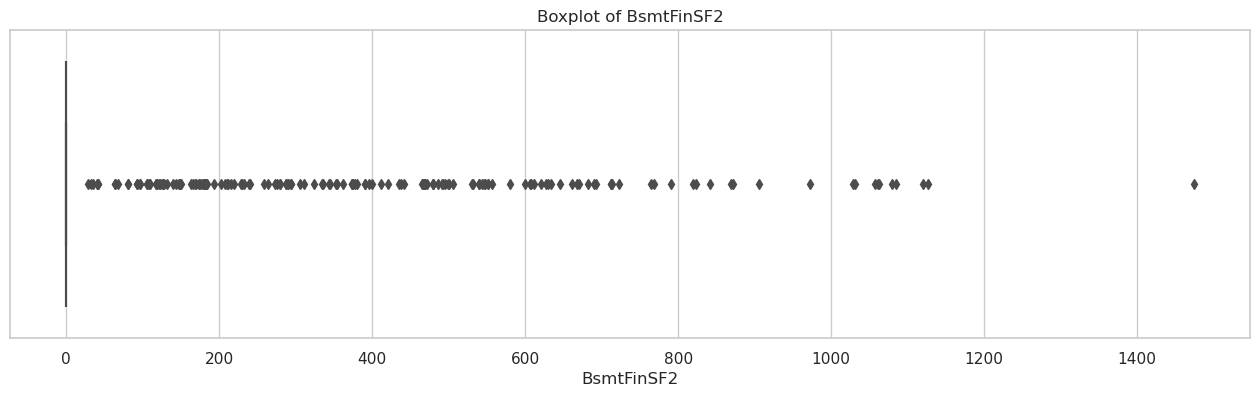

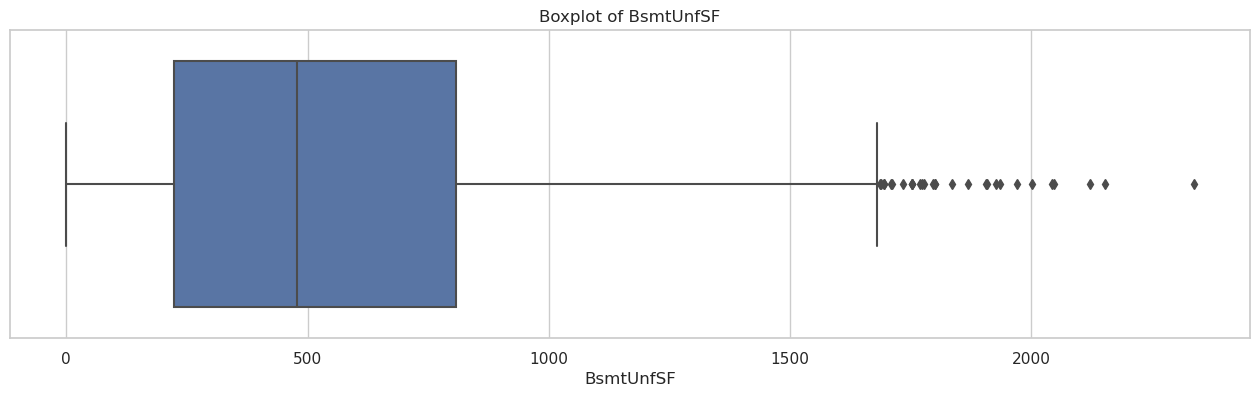

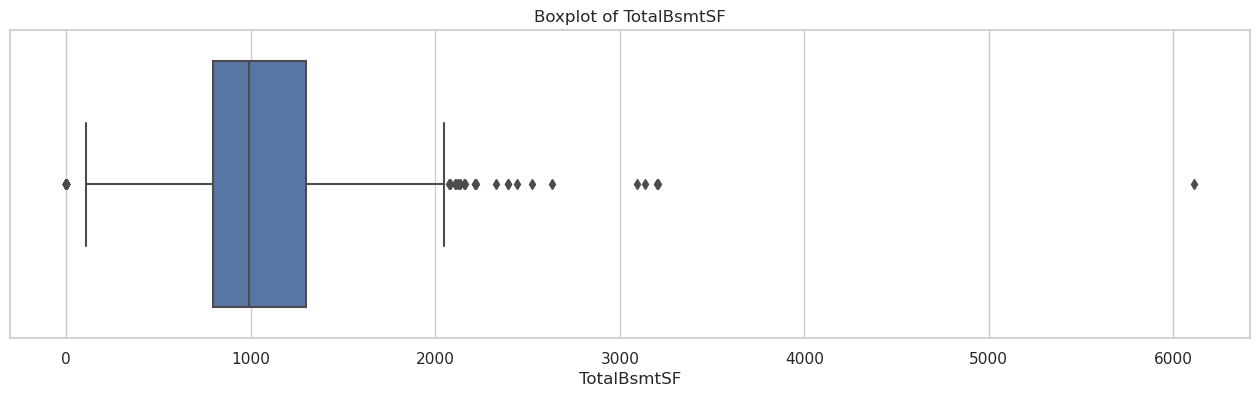

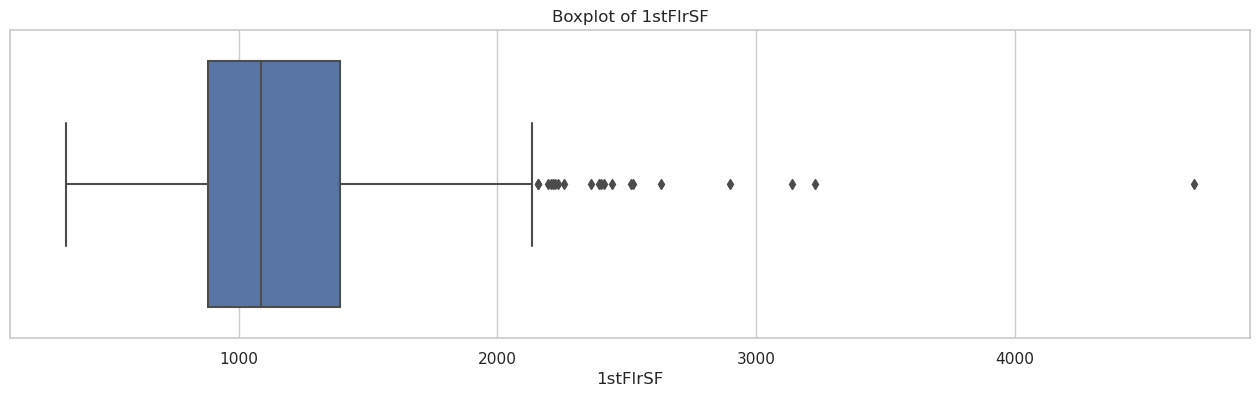

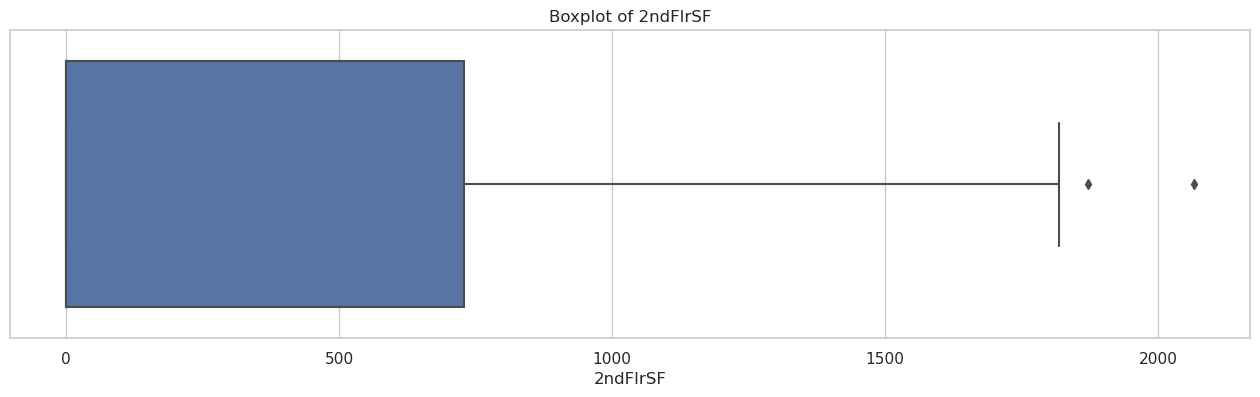

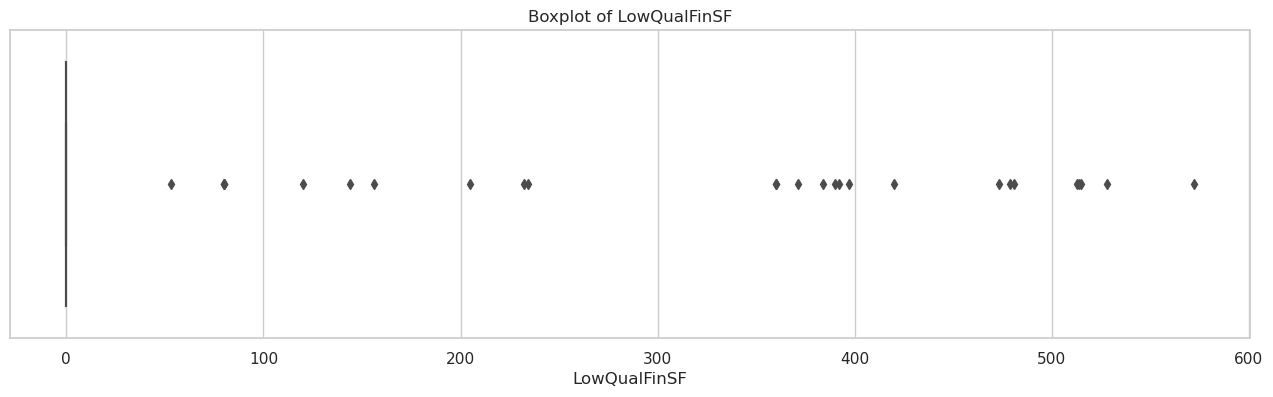

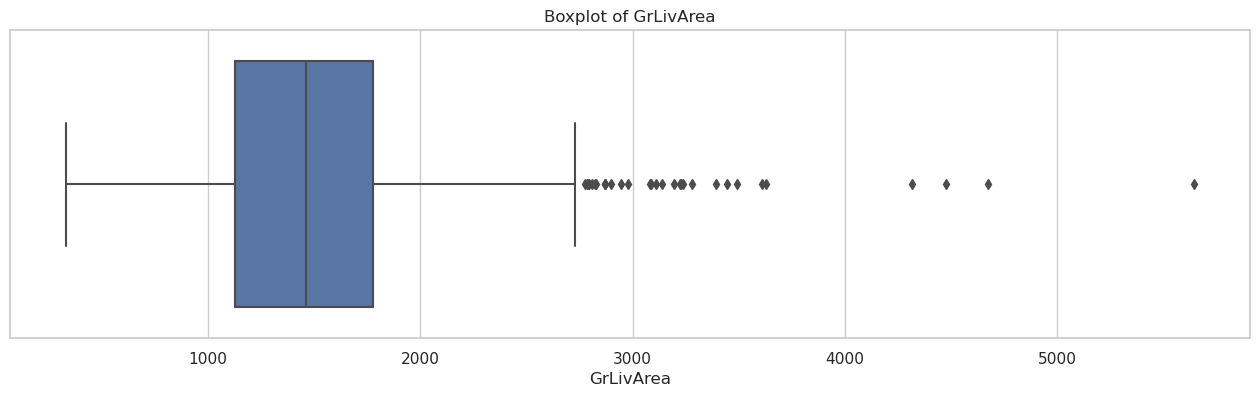

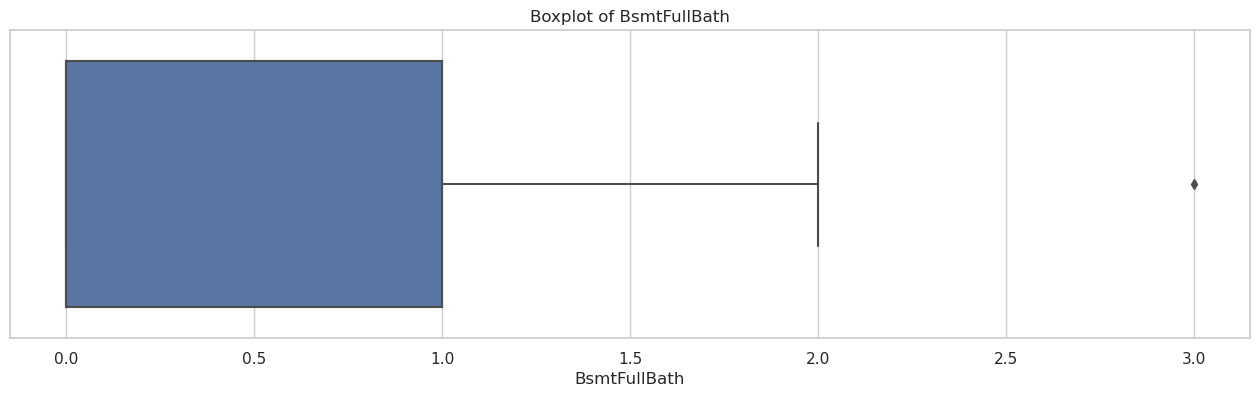

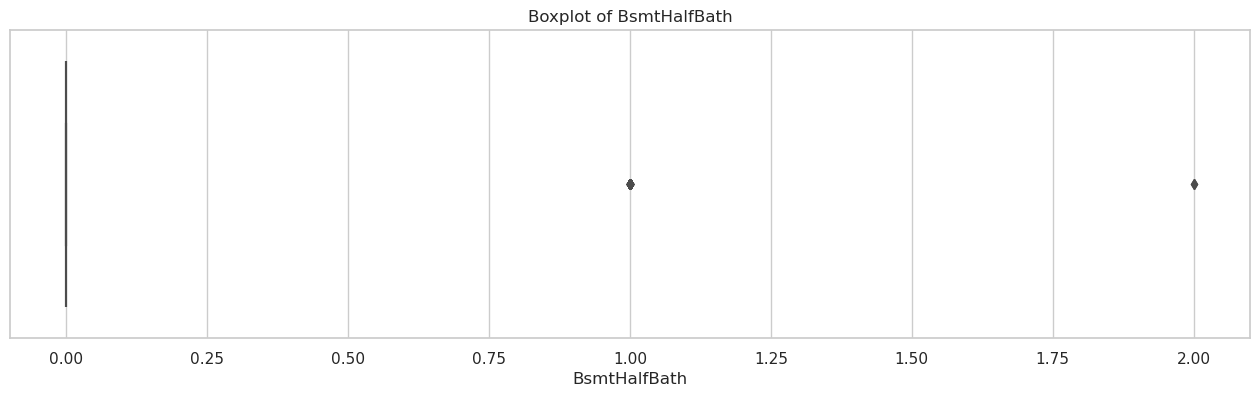

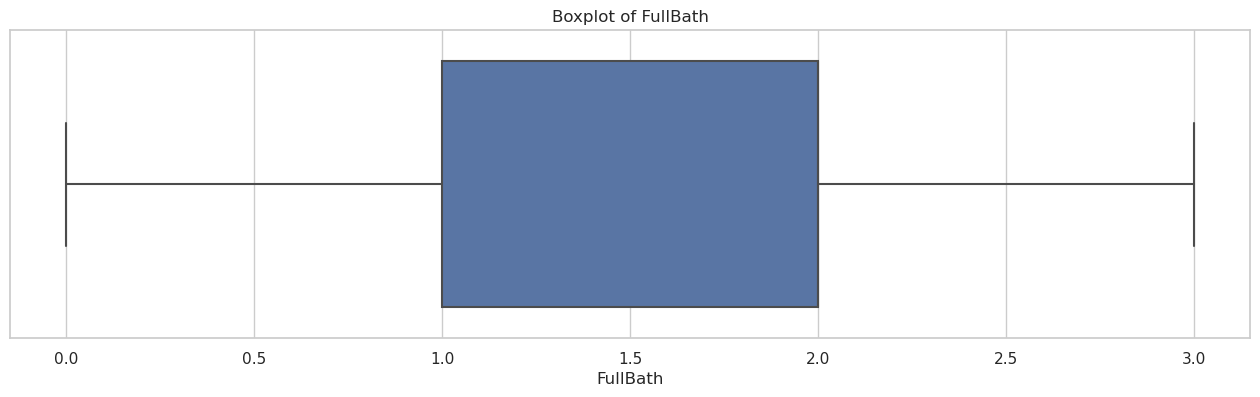

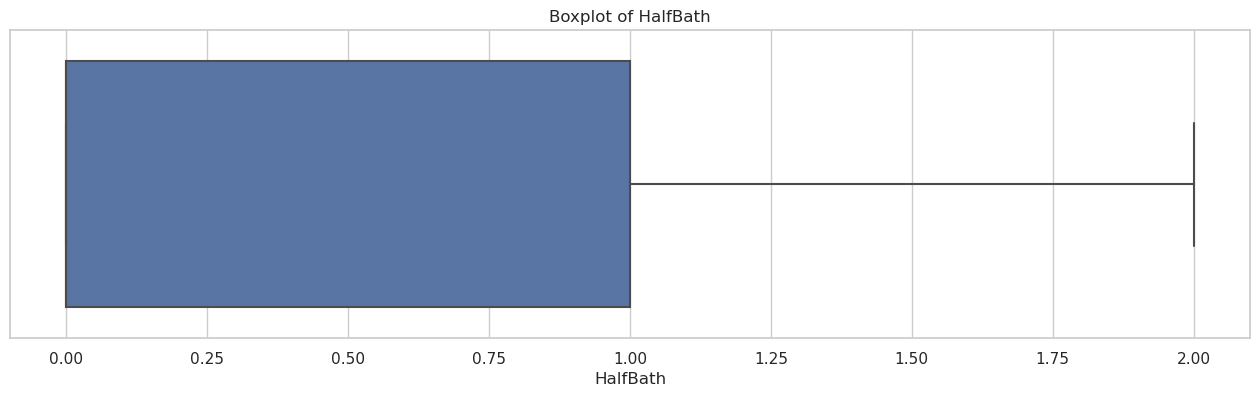

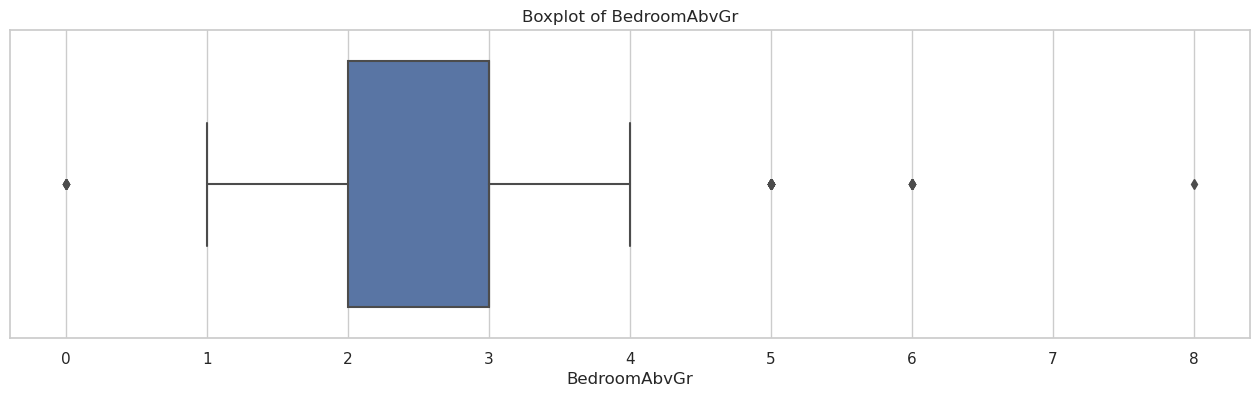

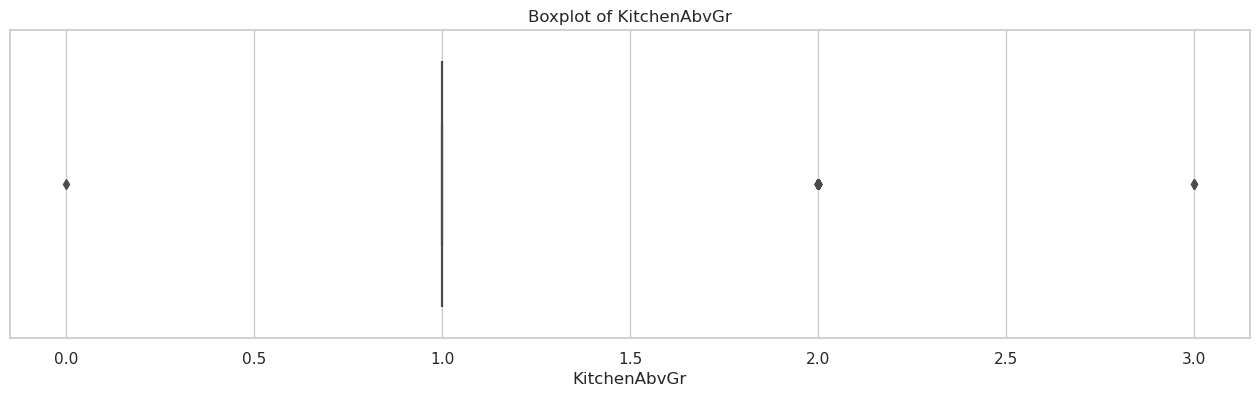

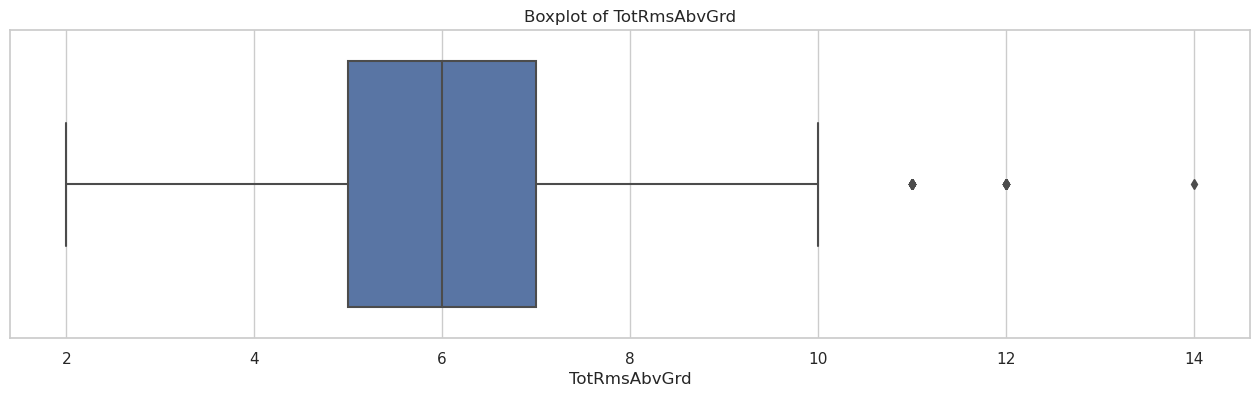

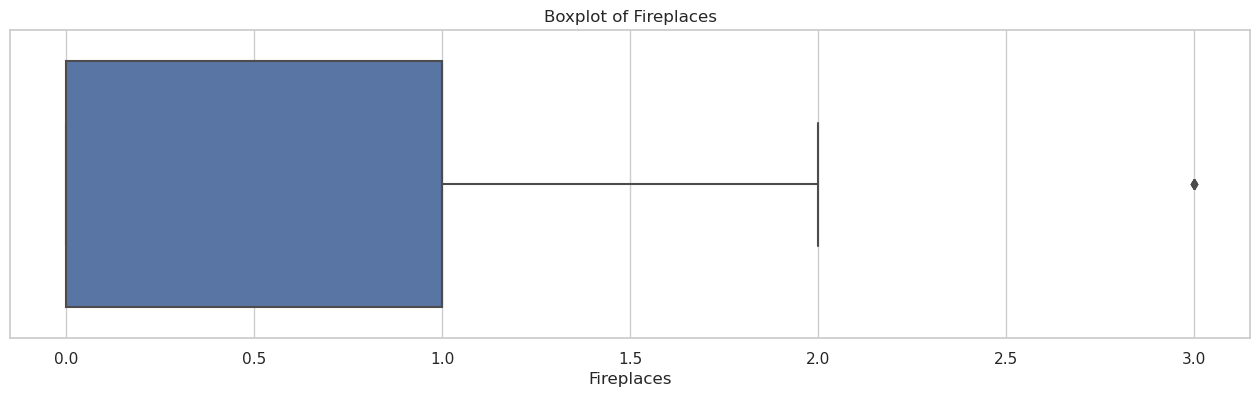

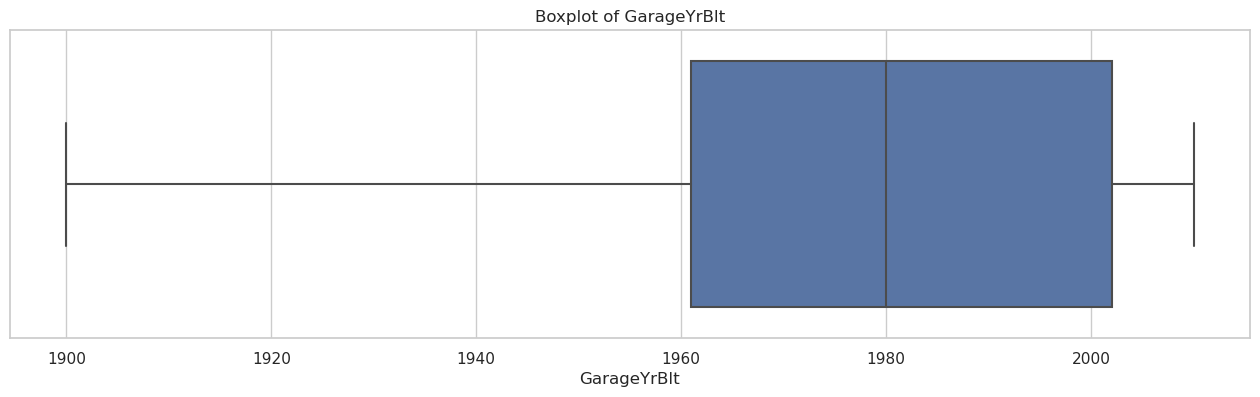

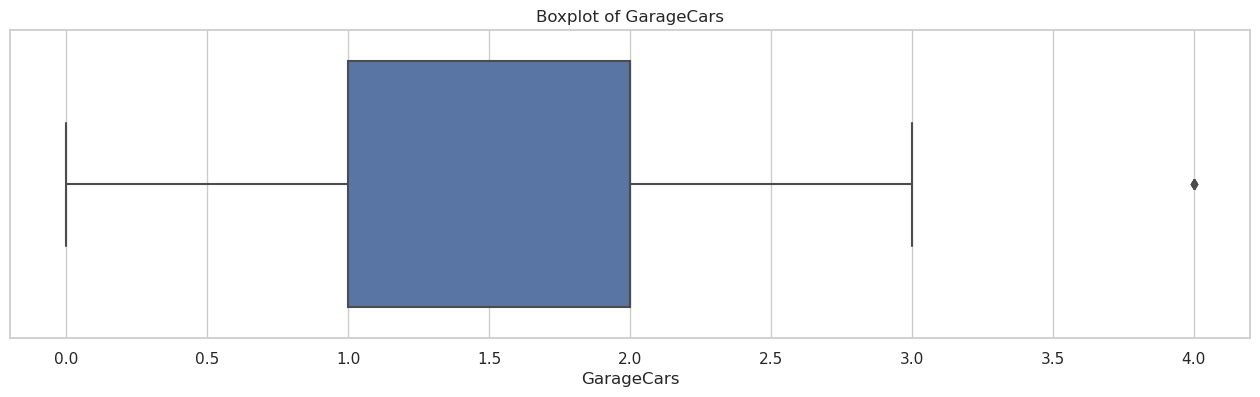

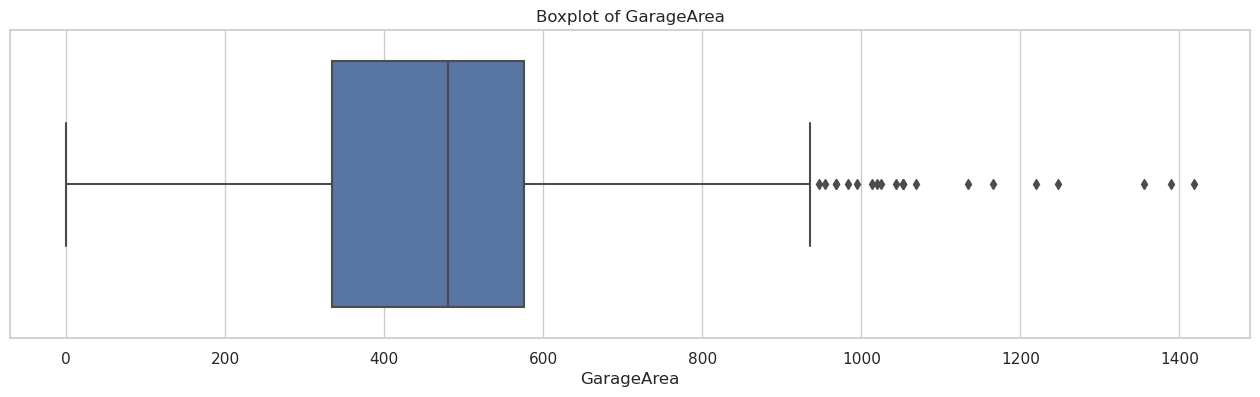

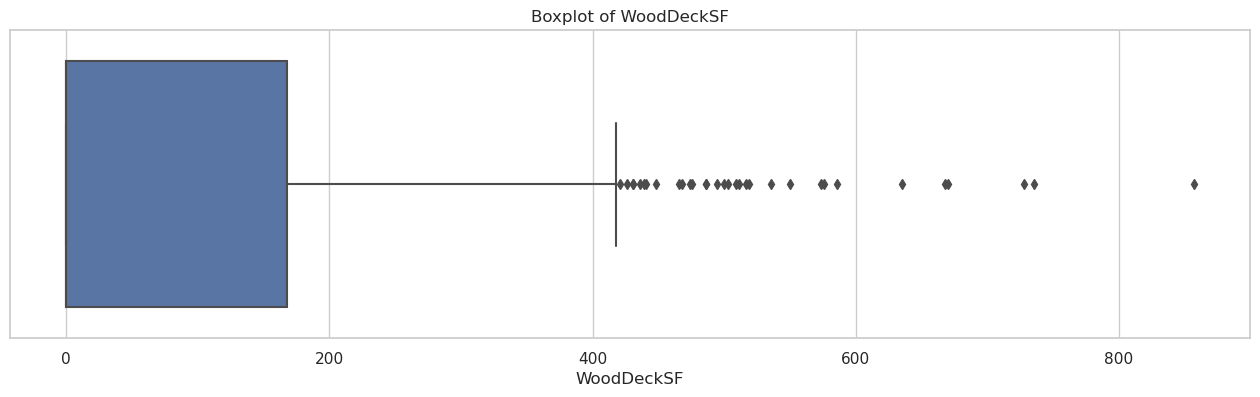

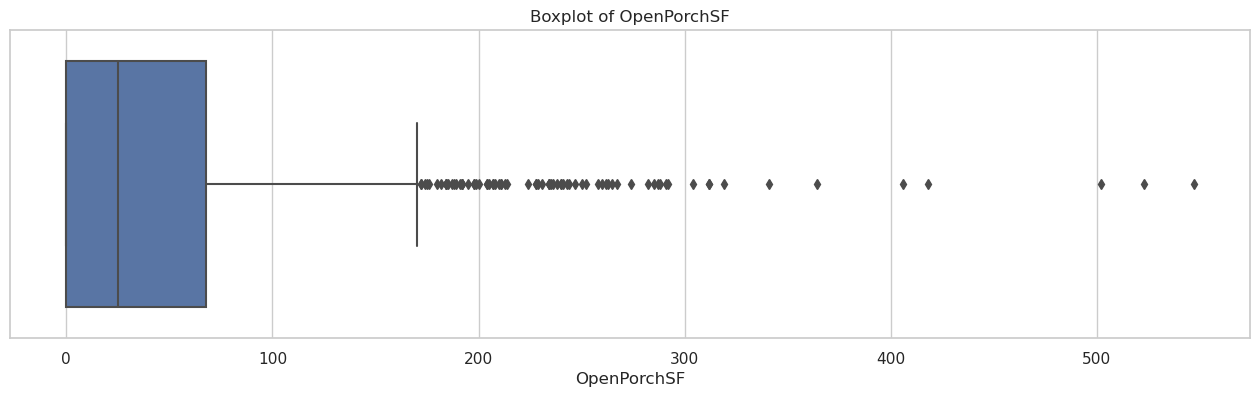

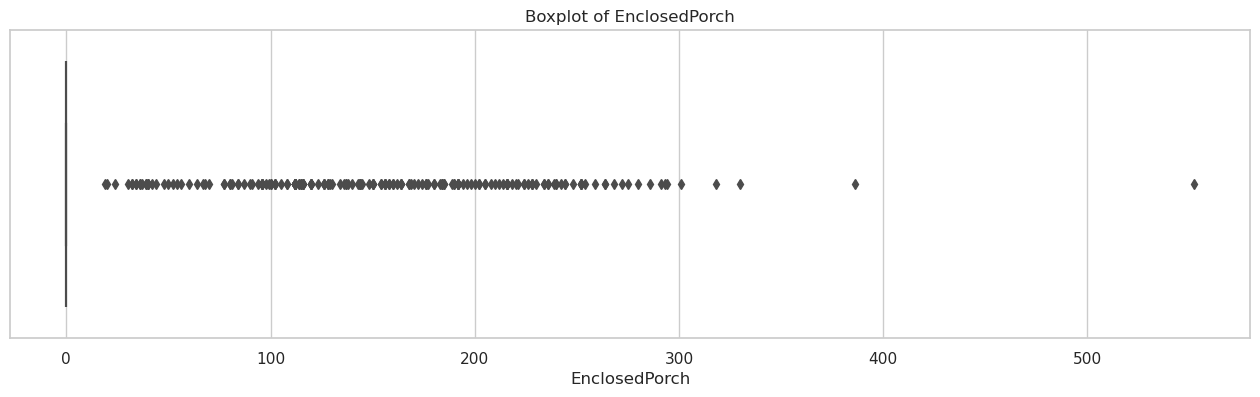

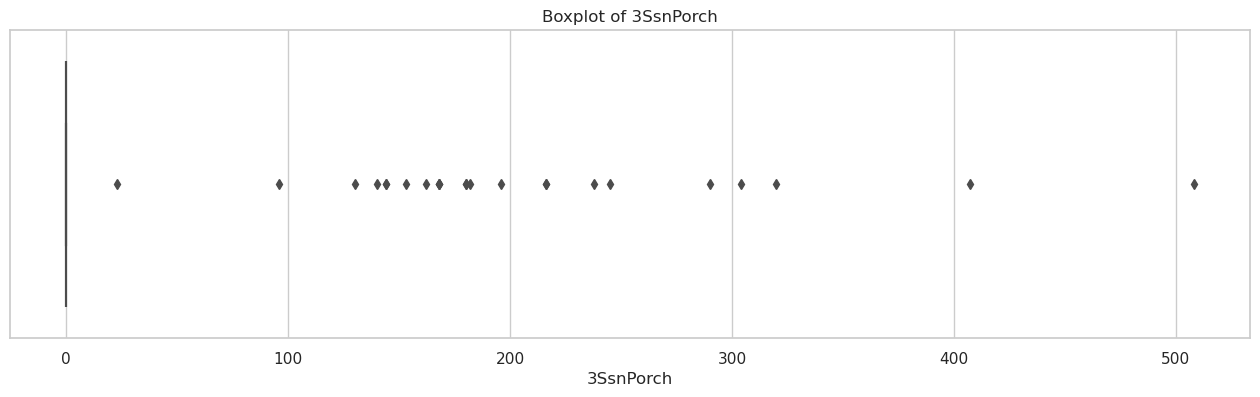

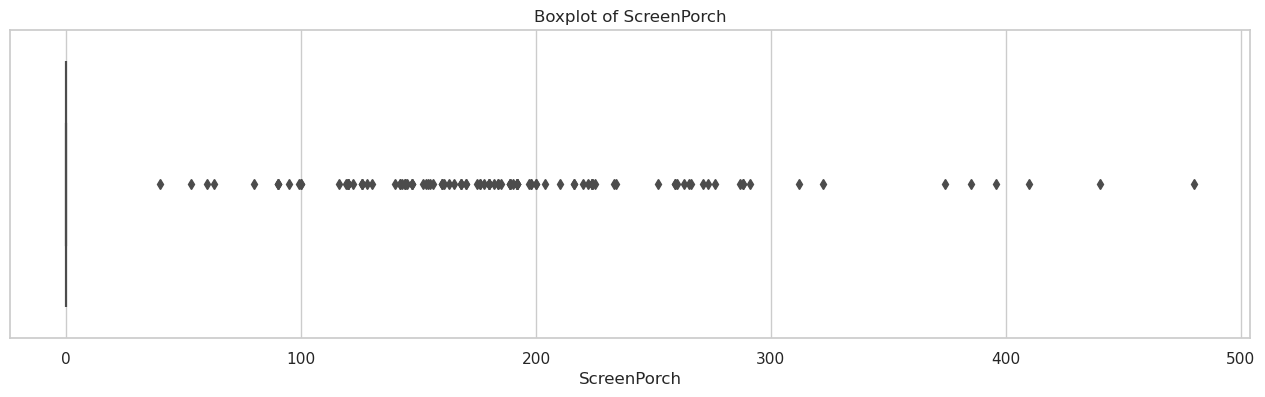

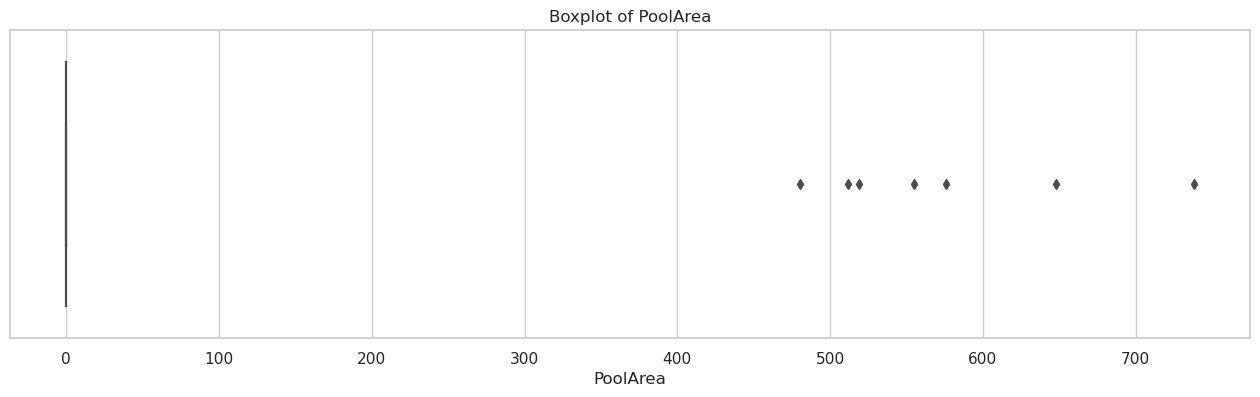

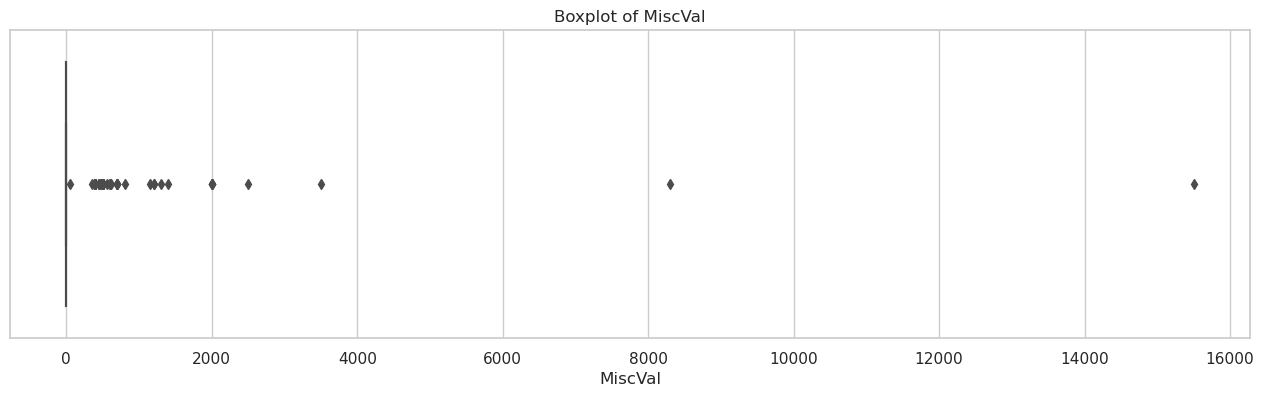

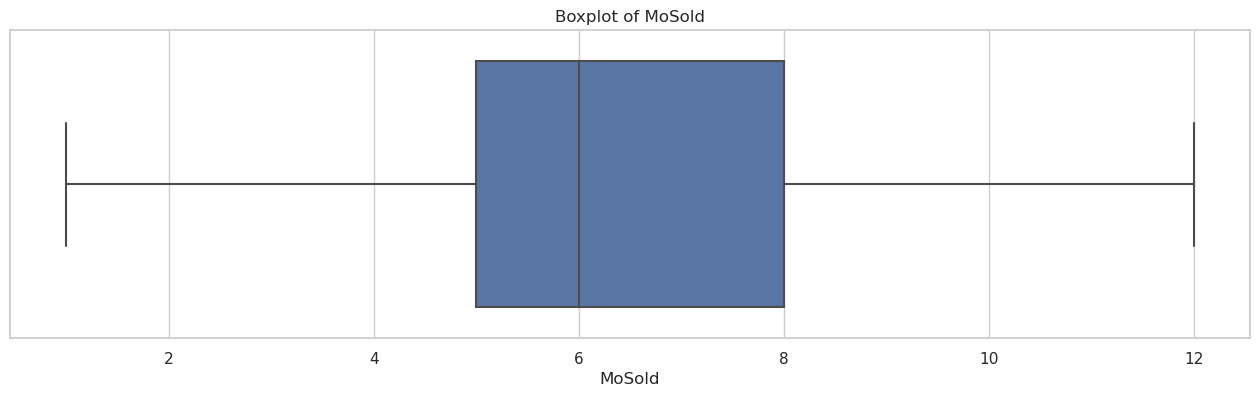

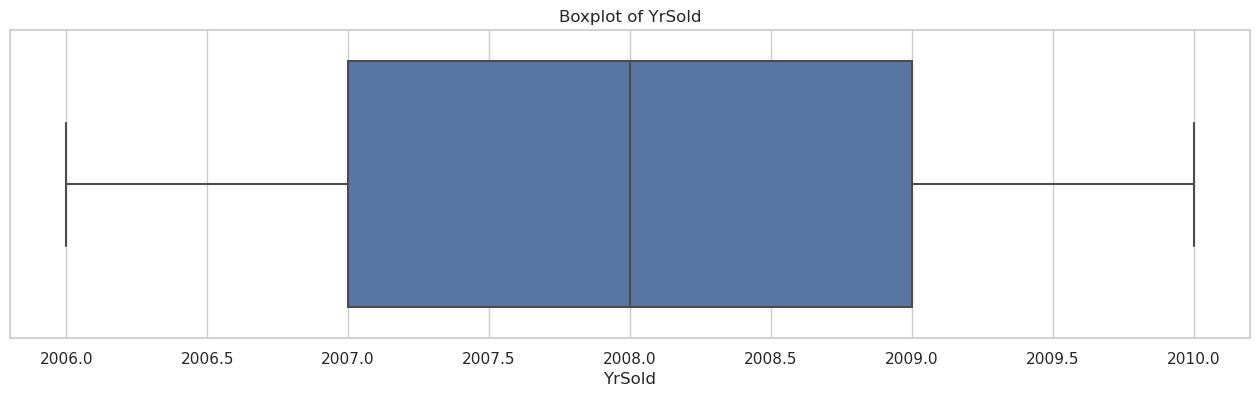

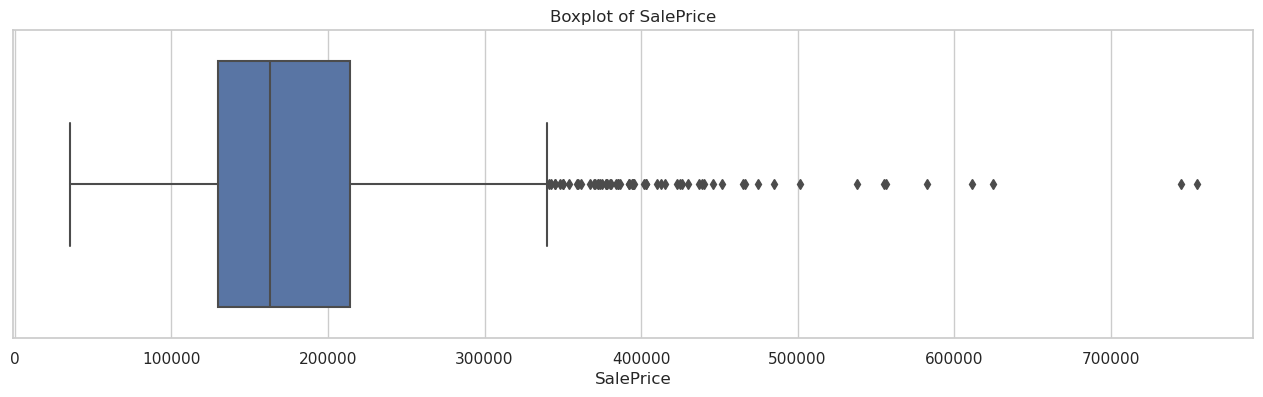

In [16]:
numerical_df = df_train.select_dtypes(exclude=['object'])
numerical_df = numerical_df.drop(["Id"], axis=1)

for column in numerical_df.columns:
    plt.figure(figsize=(16, 4))
    sns.set_theme(style="whitegrid")
    sns.boxplot(x=numerical_df[column])
    plt.xlabel(column)
    plt.title(f'Boxplot of {column}')
    plt.show()

In [17]:
# Merge dataframes (rows), reset the index
df = pd.concat([df_train, df_test], ignore_index=True)
df.reset_index(drop=True, inplace=True)

# Check the new shape
print(df.shape)

(2919, 81)


In [22]:
# missing rows
df.isnull().sum().sort_values(ascending=False).head(40)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
MasVnrType       1766
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageCond        159
GarageQual        159
GarageFinish      159
GarageYrBlt       159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrArea         23
MSZoning            4
Utilities           2
BsmtFullBath        2
Functional          2
BsmtHalfBath        2
GarageCars          1
SaleType            1
Exterior1st         1
Exterior2nd         1
KitchenQual         1
GarageArea          1
Electrical          1
BsmtFinSF1          1
TotalBsmtSF         1
BsmtFinSF2          1
BsmtUnfSF           1
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
dtype: int64

In [23]:
print(df['PoolQC'].unique())
print("")
print(df['PoolQC'].value_counts())

[nan 'Ex' 'Fa' 'Gd']

PoolQC
Ex    4
Gd    4
Fa    2
Name: count, dtype: int64


In [24]:
df['PoolQC'].fillna('None', inplace = True)

In [25]:
# List of features where NA means "None"
none_fill = [
    "PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
    "GarageType", "GarageFinish", "GarageQual", "GarageCond",
    "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "MasVnrType"
]

for col in none_fill:
    df[col] = df[col].fillna("None")

In [26]:
zero_fill = [
    "GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea", "BsmtFullBath", "BsmtHalfBath"
]

for col in zero_fill:
    df[col] = df[col].fillna(0)

In [27]:
mode_fill = [
    "MSZoning", "Functional", "KitchenQual", "Electrical", "SaleType", 
    "Exterior1st", "Exterior2nd", "Utilities"
]

for col in mode_fill:
    df[col] = df[col].fillna(df[col].mode()[0])

In [28]:
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [30]:
# now it doesn't have missing values, we do not touch sales price because its the variable that we want to evaluate
print(df.isnull().sum().sort_values(ascending=False).head(20))

SalePrice       1459
GarageYrBlt        0
GarageType         0
FireplaceQu        0
Fireplaces         0
Functional         0
TotRmsAbvGrd       0
KitchenQual        0
KitchenAbvGr       0
BedroomAbvGr       0
FullBath           0
BsmtHalfBath       0
BsmtFullBath       0
GrLivArea          0
LowQualFinSF       0
2ndFlrSF           0
1stFlrSF           0
Electrical         0
CentralAir         0
HalfBath           0
dtype: int64


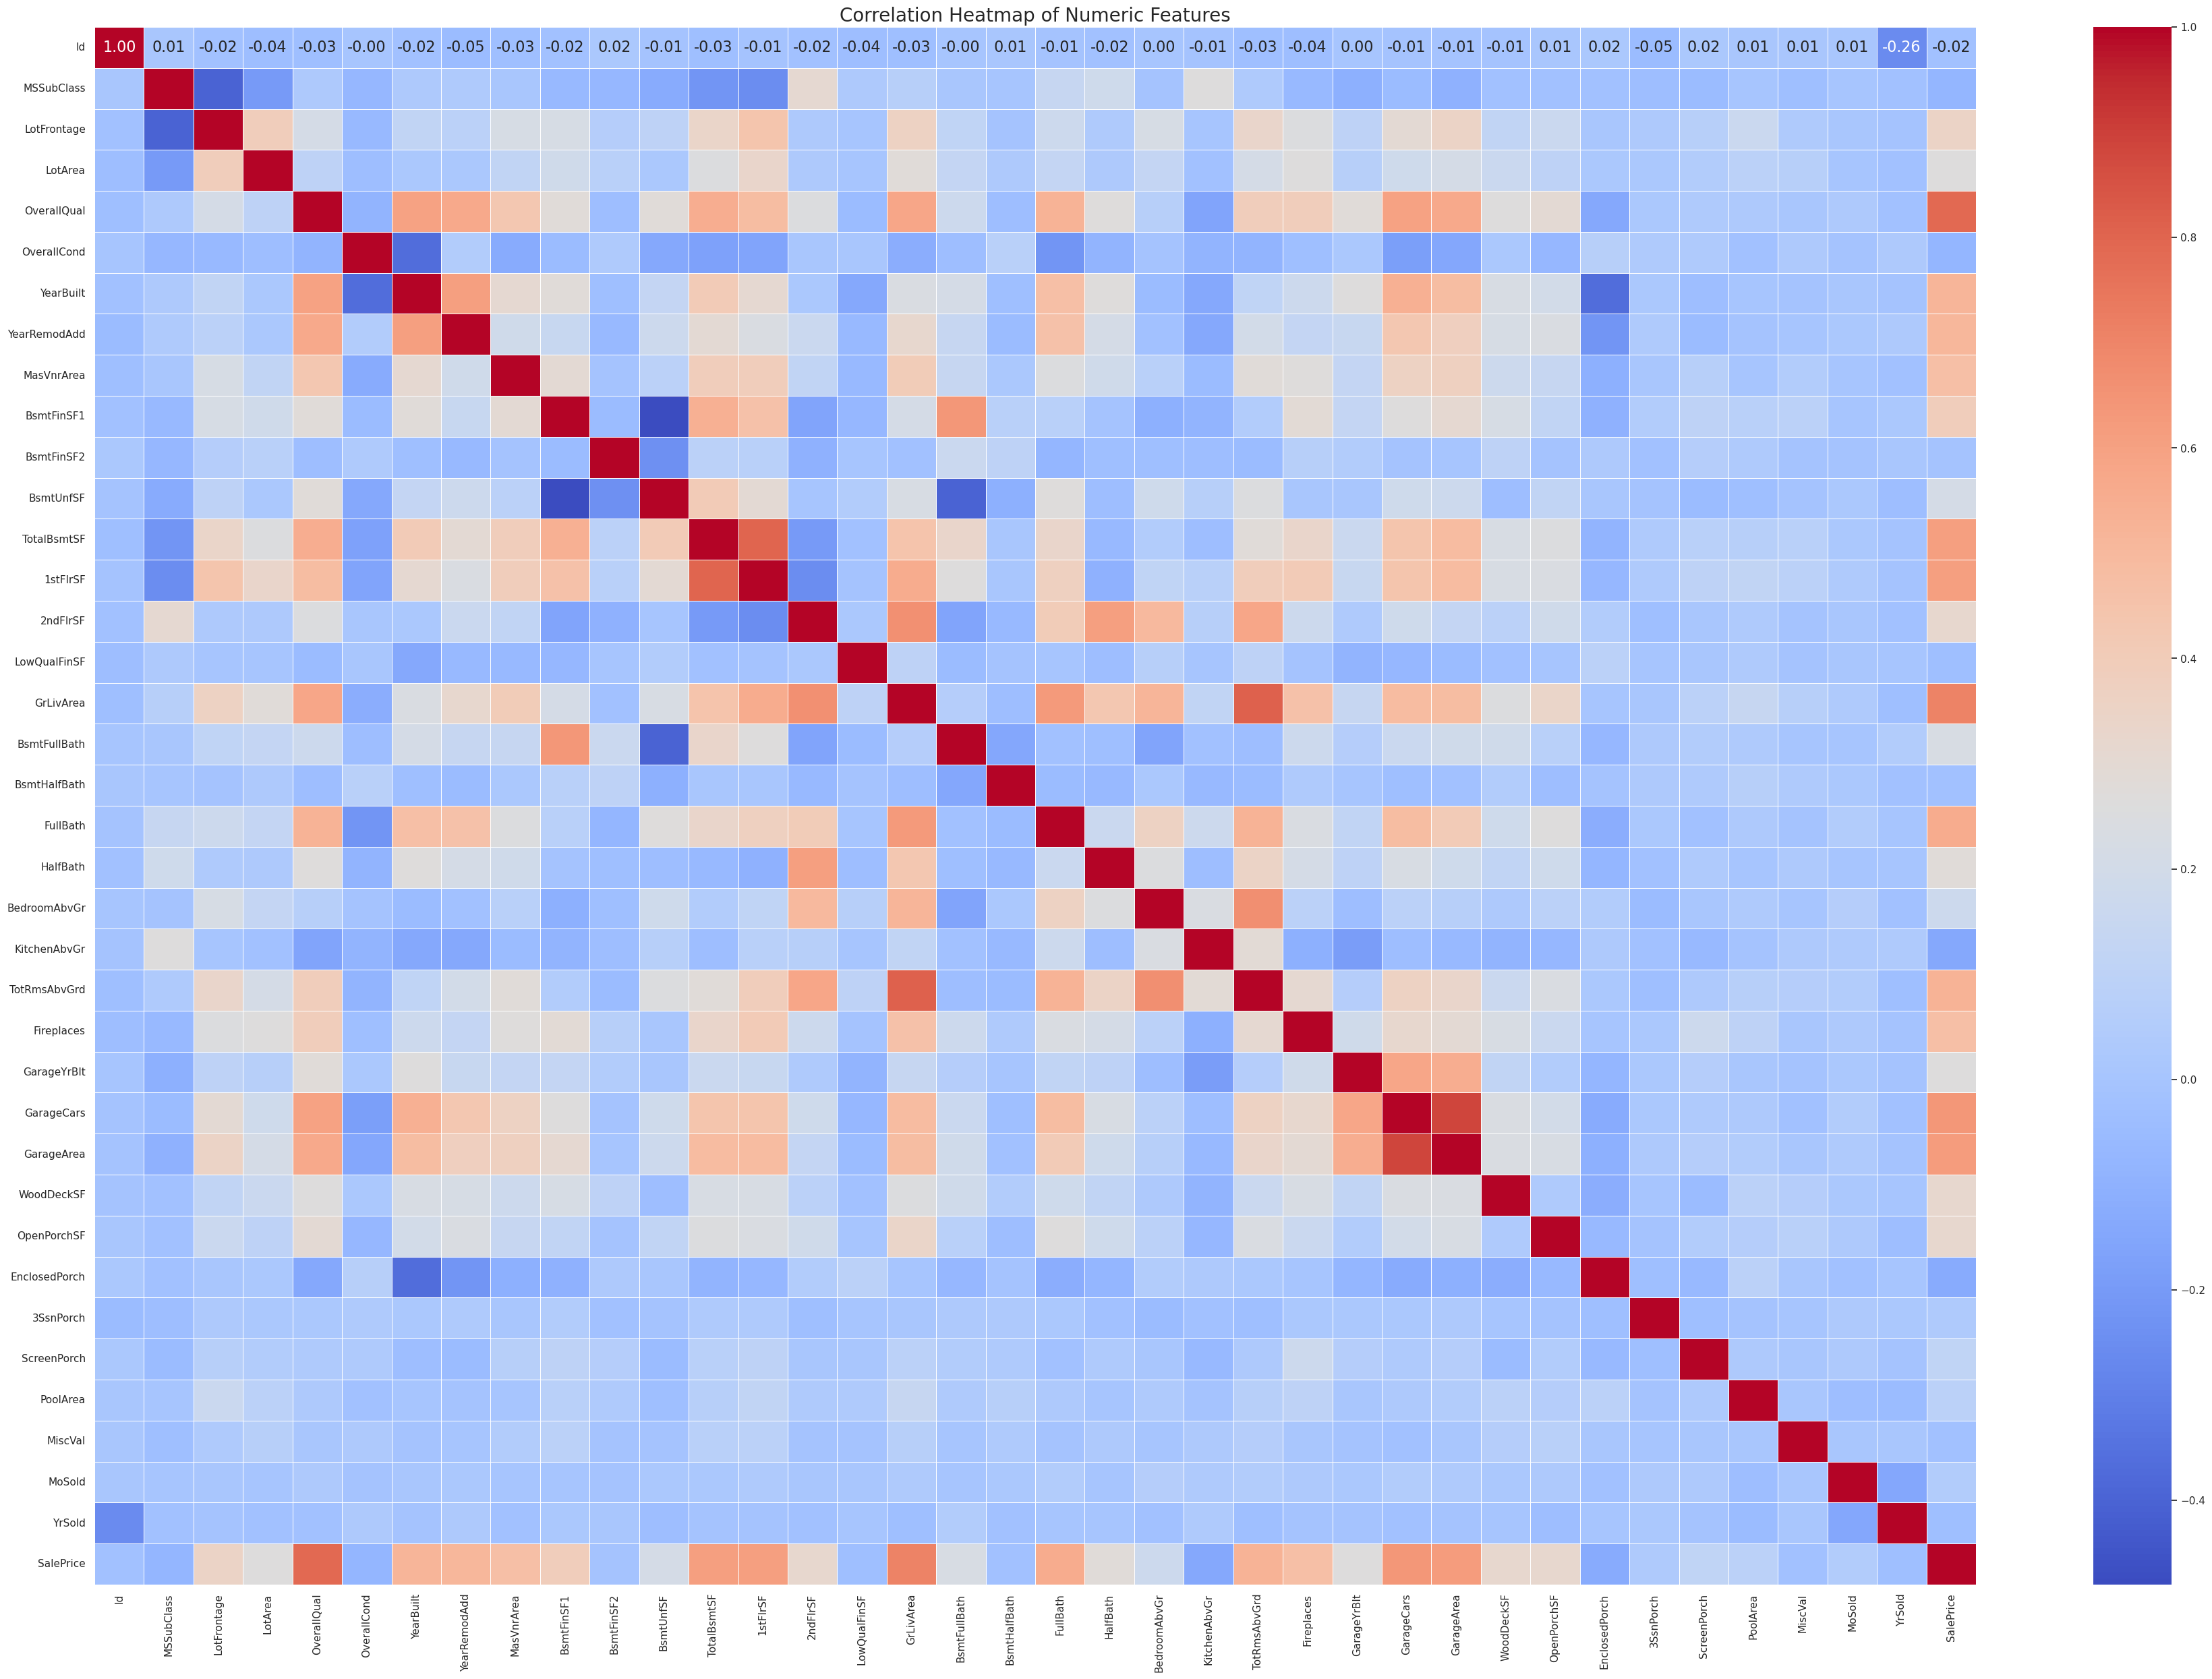

In [32]:
# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute the correlation matrix, rounded to 2 decimals
df_corr = numeric_df.corr().round(2)

# heatmap
plt.figure(figsize=(45, 30))  
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt='0.2f', linewidths=0.5, annot_kws = {"size": 16})
plt.title("Correlation Heatmap of Numeric Features", fontsize=20)
plt.show()

In [37]:

if all(col in df.columns for col in ['YrSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']):
    df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']
    df.drop(['YrSold', 'MoSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd'], axis=1, inplace=True, errors='ignore')

if all(col in df.columns for col in ['BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF']):
    df['TotalBsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
    df['TotalFlrSF'] = df['1stFlrSF'] + df['2ndFlrSF']
    df.drop(['BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True, errors='ignore')


In [38]:
# Combine all baths (full bath = 1, half bath = 0.5)
df['TotalBaths'] = (
    df['FullBath'] +
    0.5 * df['HalfBath'] +
    df['BsmtFullBath'] +
    0.5 * df['BsmtHalfBath']
)

# Drop the original columns (all at once, for brevity)
df.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=True)

In [39]:
# Avoid division by zero and handle NaNs
df['GarageAreaPerCar'] = df['GarageArea'] / df['GarageCars']

# Fill NaN values with 0 (e.g., if GarageCars is 0 or NaN)
df['GarageAreaPerCar'] = df['GarageAreaPerCar'].fillna(0)

# Drop the original GarageArea column
df.drop(['GarageArea'], axis=1, inplace=True)

In [40]:
# Create a list of numerical columns (excluding objects and 'SalePrice')
numerical_cols = [cname for cname in df.columns 
                  if df[cname].dtype != 'object' and cname != 'SalePrice']

# Create a DataFrame with these numerical features
skew_df = pd.DataFrame(numerical_cols, columns=['Feature'])

# Compute skewness for each feature
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df[feature].dropna()))

# Take the absolute value of skew
skew_df['Absolute Skew'] = skew_df['Skew'].abs()

# Flag features as 'Skewed' if absolute skew >= 0.5
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: x >= 0.5)

# Display skewed features
print(skew_df[skew_df['Skewed']])

           Feature       Skew  Absolute Skew  Skewed
1       MSSubClass   1.375457       1.375457    True
2      LotFrontage   1.505704       1.505704    True
3          LotArea  12.822431      12.822431    True
5      OverallCond   0.570312       0.570312    True
6       MasVnrArea   2.613592       2.613592    True
7        BsmtUnfSF   0.919339       0.919339    True
8      TotalBsmtSF   1.156894       1.156894    True
9     LowQualFinSF  12.088761      12.088761    True
10       GrLivArea   1.269358       1.269358    True
12    KitchenAbvGr   4.302254       4.302254    True
13    TotRmsAbvGrd   0.758367       0.758367    True
14      Fireplaces   0.733495       0.733495    True
16      WoodDeckSF   1.842433       1.842433    True
17     OpenPorchSF   2.535114       2.535114    True
18   EnclosedPorch   4.003891       4.003891    True
19       3SsnPorch  11.376065      11.376065    True
20     ScreenPorch   3.946694       3.946694    True
21        PoolArea  16.898328      16.898328  

This shows many features are highly skewed, especially LotArea, LowQualFinSF, 3SsnPorch, PoolArea, and MiscVal. This skewness will need to be addressed (e.g., with transformations) for most regression models to perform optimally.

In [43]:
import numpy as np

skewed_features = skew_df.query("Skewed == True")['Feature'].values
for column in skewed_features:
    df[column] = np.log1p(df[column])

This code applies a log1p transformation to highly skewed numerical features. The goal is to reduce skewness, making data distributions more symmetrical and Gaussian-like, which is crucial for improving the performance and assumptions of many machine learning models, particularly linear regression-based ones.

In [44]:
# Separate numerical features, excluding 'SalePrice' and 'Id'
num_cols = df.select_dtypes(include=['number']).columns.drop(['SalePrice', 'Id'])
df_numerical = df[num_cols].copy()

# Separate categorical features
cat_cols = df.select_dtypes(include='object').columns
df_categorical = df[cat_cols].copy()

df_numerical.head(), df_categorical.head()

(   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  MasVnrArea  \
 0    4.110874     4.189655  9.042040            7     1.791759    5.283204   
 1    3.044522     4.394449  9.169623            6     2.197225    0.000000   
 2    4.110874     4.234107  9.328212            7     1.791759    5.093750   
 3    4.262680     4.110874  9.164401            7     1.791759    0.000000   
 4    4.110874     4.442651  9.565284            8     1.791759    5.860786   
 
    BsmtUnfSF  TotalBsmtSF  LowQualFinSF  GrLivArea  BedroomAbvGr  \
 0   5.017280     6.753438           0.0   7.444833             3   
 1   5.652489     7.141245           0.0   7.141245             3   
 2   6.075346     6.825460           0.0   7.488294             3   
 3   6.293419     6.629363           0.0   7.448916             3   
 4   6.196444     7.044033           0.0   7.695758             4   
 
    KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  WoodDeckSF  \
 0      0.693147      2.197225    0.00

This code separates the DataFrame into numerical and categorical features, making preprocessing more organized. Distinguishing feature types allows for tailored transformations, encoding, and analysis essential for effective machine learning pipelines.

In [45]:
# Define mappings for ordinal variables
ordinal_maps = {
    'ExterQual':   {"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
    'ExterCond':   {"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
    'BsmtQual':    {"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
    'BsmtCond':    {"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
    'HeatingQC':   {"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
    'KitchenQual': {"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
    'FireplaceQu': {"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
    'GarageQual':  {"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
    'GarageCond':  {"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
    'PoolQC':      {"None":0, "Fa":1, "Gd":2, "Ex":3},
    # ... add all other mappings from your second screenshot here ...
    'LotShape':    {"None":0, "IR3":1, "IR2":2, "IR1":3, "Reg":4},
    'LandContour': {"None":0, "Low":1, "Bnk":2, "HLS":3, "Lvl":4},
    'LandSlope':   {"None":0, "Sev":1, "Mod":2, "Gtl":3},
    'BsmtExposure':{"None":0, "No":1, "Mn":2, "Av":3, "Gd":4},
    'BsmtFinType1':{"None":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6},
    'BsmtFinType2':{"None":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6},
    'Utilities':   {"None":0, "ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub":4},
    'CentralAir':  {"N":0, "Y":1},
    'Functional':  {"None":0, "Sal":1, "Sev":2, "Maj2":3, "Maj1":4, "Mod":5, "Min2":6, "Min1":7, "Typ":8},
    'GarageFinish':{"None":0, "Unf":1, "RFn":2, "Fin":3},
    'PavedDrive':  {"None":0, "N":1, "P":2, "Y":3},
    'Fence':       {"None":0, "MnWw":1, "GdWo":2, "MnPrv":3, "GdPrv":4},
}

# Apply mapping to all relevant columns
for col, mapping in ordinal_maps.items():
    if col in df.columns:
        df[col] = df[col].map(mapping).astype('Int64')

This approach efficiently encodes ordinal categorical features into ordered integers, preserving their natural ranking for machine learning algorithms. It simplifies preprocessing, supports reproducibility, and reduces code repetition, ensuring consistency and clarity for downstream modeling tasks.


In [48]:
# Define your ordinal columns (make sure these match your earlier encoding)
ordinal_1 = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
    'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'
]
ordinal_2 = [
    'LotShape', 'LandContour', 'LandSlope', 'BsmtExposure', 'BsmtFinType1',
    'BsmtFinType2', 'Utilities', 'CentralAir', 'Functional', 'GarageFinish',
    'PavedDrive', 'Fence'
]

# Drop all ordinal columns from the categorical DataFrame
df_categorical_non_ordinal = df_categorical.drop(columns=ordinal_1 + ordinal_2, errors='ignore')

# One-hot encode the remaining categorical columns
df_encoded = pd.get_dummies(df_categorical_non_ordinal, drop_first=True)

# (Optional) Check the results
print(df_encoded.shape)
print(df_encoded.head(5))

(2919, 142)
   MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Pave  \
0        False        False         True        False         True   
1        False        False         True        False         True   
2        False        False         True        False         True   
3        False        False         True        False         True   
4        False        False         True        False         True   

   Alley_None  Alley_Pave  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  \
0        True       False              False          False          False   
1        True       False              False           True          False   
2        True       False              False          False          False   
3        True       False              False          False          False   
4        True       False              False           True          False   

   LotConfig_Inside  Neighborhood_Blueste  Neighborhood_BrDale  \
0              True             

This output shows a DataFrame (2919 rows, 142 columns) after one-hot encoding categorical features. Original categorical columns like MSZoning and Neighborhood have been expanded into multiple new binary (True/False) columns, representing each unique category. This transformation is vital for machine learning models, which require numerical input.

In [50]:
train_size = df_train.shape[0]

In [56]:
# Split the combined dataframe back into train and test sets using the original train size
df_train_split = df.iloc[:train_size, :].copy()
df_test_split = df.iloc[train_size:, :].copy()

# Drop 'Id' from both sets
df_train_split.drop(['Id'], axis=1, inplace=True)
df_test_split.drop(['Id'], axis=1, inplace=True)

# Log-transform the target variable for training
log_target = np.log(df_train_split['SalePrice'])

# Remove target from training features
df_train_split.drop(['SalePrice'], axis=1, inplace=True)

# Just in case, drop 'SalePrice' from test if it exists (should not be there)
if 'SalePrice' in df_test_split.columns:
    df_test_split.drop(['SalePrice'], axis=1, inplace=True)

In [57]:
import pandas as pd

# One-hot encode all categorical columns (object type) in your features
df_train_xgb = pd.get_dummies(df_train_split, drop_first=True)
df_test_xgb = pd.get_dummies(df_test_split, drop_first=True)

# Align the columns of train and test (sometimes test is missing some categories)
df_train_xgb, df_test_xgb = df_train_xgb.align(df_test_xgb, join='left', axis=1, fill_value=0)

# Now fit XGBoost model with the numeric-only data
xgb_model.fit(df_train_xgb, log_target)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [61]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# For CatBoost: pass categorical columns as fit_params
cat_features = [col for col in df_train_split.columns if df_train_split[col].dtype == 'object']
catboost_rmse = np.exp(np.sqrt(-cross_val_score(
    catboost_model, df_train_split, log_target,
    scoring='neg_mean_squared_error', cv=kf,
    fit_params={'cat_features': cat_features}
)))

# For XGBoost: use numeric-encoded data
xgb_rmse = np.exp(np.sqrt(-cross_val_score(
    xgb_model, df_train_xgb, log_target,
    scoring='neg_mean_squared_error', cv=kf
)))

print("CatBoost average RMSE:", np.mean(catboost_rmse))
print("XGBoost average RMSE:", np.mean(xgb_rmse))

CatBoost average RMSE: 1.1328710135288143
XGBoost average RMSE: 1.1428725183311061


When I interpret RMSE (Root Mean Squared Error), I see it as a measure of how close my model’s predicted prices are to the actual sale prices on average. In my results, CatBoost achieved an average RMSE of 1.13 and XGBoost 1.14, both calculated on the log scale to match the competition’s metric. A lower RMSE means my model’s predictions are more accurate—typically, the closer RMSE is to 0, the better. In the context of this competition, strong models often achieve an RMSE between 0.11 and 0.13, so my results are competitive. To know if this is “good,” I compare my RMSE to simple baselines—like predicting the average sale price—or to public leaderboard scores. My intention is to minimize RMSE to provide fair, accurate price estimates, ensuring reliable valuations and supporting better pricing, investment, and risk management decisions in real estate.

In [67]:
# Combine predictions (80% CatBoost, 20% XGBoost)
final_predictions = (
    0.80 * np.exp(catboost_model.predict(df_test_split)) +
    0.20 * np.exp(xgb_model.predict(df_test_xgb))
)

# Save to CSV
output = pd.DataFrame({
    'Id': df_test.index,   # Use the original Id column!
    'SalePrice': final_predictions
})
output.to_csv('submission.csv', index=False)

In [68]:
df_test_original = pd.read_csv('test.csv')

In [69]:
# Assuming `final_predictions` is your array of predictions in the same order as test set
submission = pd.DataFrame({
    'Id': df_test_original['Id'],
    'SalePrice': final_predictions
})
submission.to_csv('submission_rr.csv', index=False)

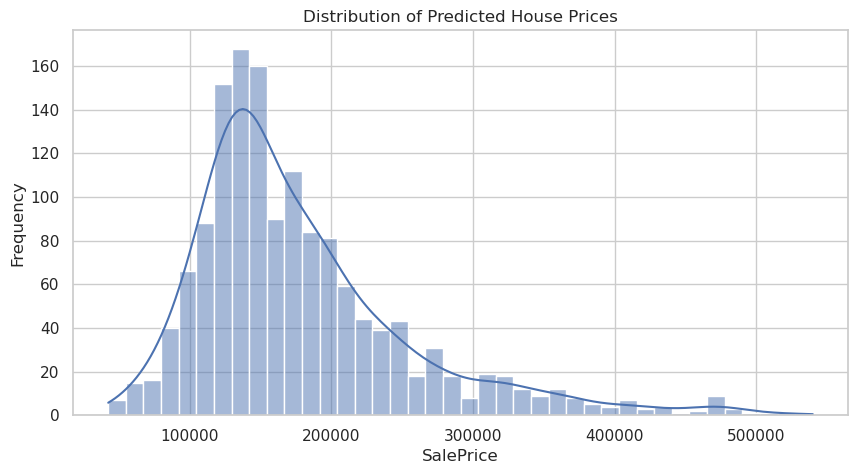

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(final_predictions, bins=40, kde=True)
plt.title("Distribution of Predicted House Prices")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

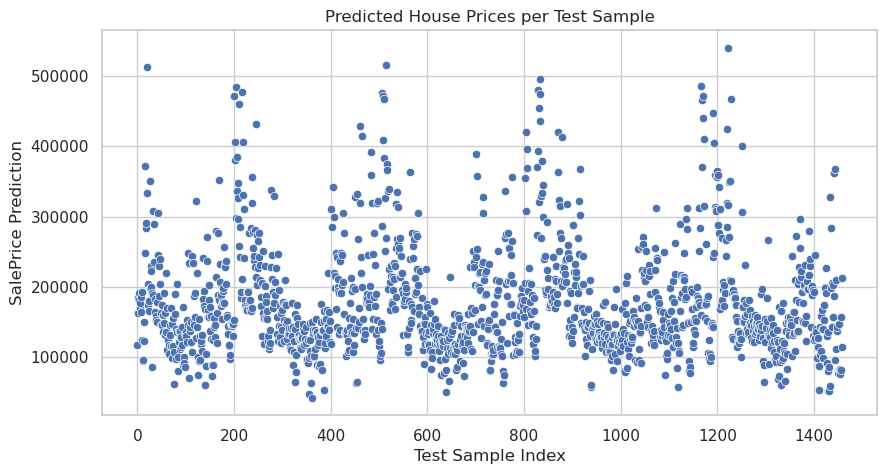

In [65]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=range(len(final_predictions)), y=final_predictions)
plt.title("Predicted House Prices per Test Sample")
plt.xlabel("Test Sample Index")
plt.ylabel("SalePrice Prediction")
plt.show()

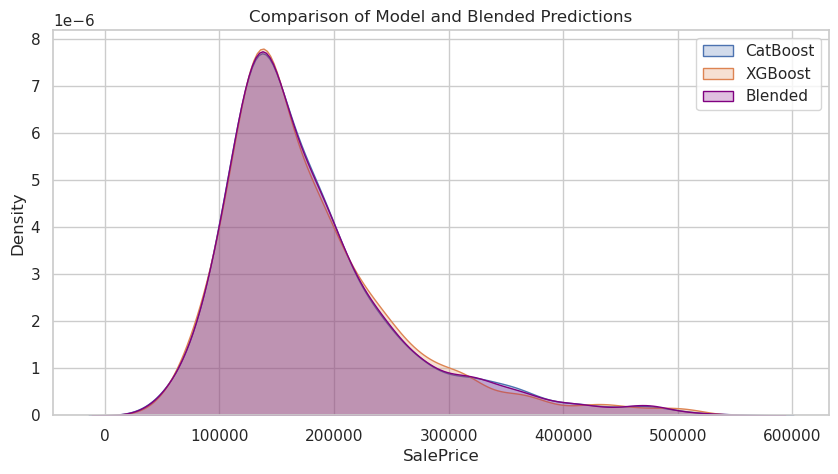

In [66]:
cat_pred = np.exp(catboost_model.predict(df_test_split))
xgb_pred = np.exp(xgb_model.predict(df_test_xgb))

plt.figure(figsize=(10,5))
sns.kdeplot(cat_pred, label='CatBoost', fill=True)
sns.kdeplot(xgb_pred, label='XGBoost', fill=True)
sns.kdeplot(final_predictions, label='Blended', fill=True, color='purple')
plt.legend()
plt.title("Comparison of Model and Blended Predictions")
plt.xlabel("SalePrice")
plt.show()

These charts reveal the predicted house price distribution is right-skewed, with most properties valued between \$100,000 and \$250,000, and a long tail of higher-priced homes. The scatter plot shows prediction spread across test samples, with no obvious gaps or clustering, suggesting model stability. The overlayed density plots confirm that CatBoost, XGBoost, and the blended model predict similar price distributions, indicating consistent performance. In real-world business, such analysis supports pricing strategies, risk management, and inventory planning by identifying price segments, outliers, and the effect of model blending on forecast stability, leading to more informed, data-driven decisions for real estate operations.
